In [ ]:
!pip install ipaddress

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import ipaddress

In [ ]:
# Load the train and test datasets
train_df = pd.read_csv("/content/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
test_df = pd.read_csv("/content/UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv")

In [ ]:
# Concatenate the train and test datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
# Ensure that IP addresses are stored correctly
combined_df['saddr'] = combined_df['saddr'].apply(lambda x: ipaddress.ip_address(x) if pd.notnull(x) else ipaddress.ip_address('0.0.0.0'))
combined_df['daddr'] = combined_df['daddr'].apply(lambda x: ipaddress.ip_address(x) if pd.notnull(x) else ipaddress.ip_address('0.0.0.0'))

In [ ]:
# Convert categorical 'proto' column to numerical
label_encoder_proto = LabelEncoder()
combined_df['proto'] = label_encoder_proto.fit_transform(combined_df['proto'].astype(str))

In [ ]:
# Fill NaN values with 0
combined_df.fillna(0, inplace=True)

In [ ]:
# Define input and output variables
X = combined_df.drop(columns=['category', 'subcategory'])
y = combined_df[['category', 'subcategory']]

In [ ]:
# Ensure category and subcategory are strings
y['category'] = y['category'].astype(str)
y['subcategory'] = y['subcategory'].astype(str)

<ipython-input-68-b3e369053b75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['category'] = y['category'].astype(str)
<ipython-input-68-b3e369053b75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['subcategory'] = y['subcategory'].astype(str)


In [ ]:
# Encode categorical target variables
label_encoder_category = LabelEncoder()
label_encoder_subcategory = LabelEncoder()
y['category'] = label_encoder_category.fit_transform(y['category'])
y['subcategory'] = label_encoder_subcategory.fit_transform(y['subcategory'])

<ipython-input-69-561df649f611>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['category'] = label_encoder_category.fit_transform(y['category'])
<ipython-input-69-561df649f611>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['subcategory'] = label_encoder_subcategory.fit_transform(y['subcategory'])


In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Extract numeric features for scaling (excluding IP addresses)
numeric_features = X_train.select_dtypes(include=[np.number])
scaler = StandardScaler()
numeric_features_scaled_train = scaler.fit_transform(numeric_features)
numeric_features_scaled_test = scaler.transform(X_test.select_dtypes(include=[np.number]))

In [ ]:
# Create the final scaled DataFrame
X_train_scaled = pd.DataFrame(numeric_features_scaled_train, columns=numeric_features.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(numeric_features_scaled_test, columns=numeric_features.columns, index=X_test.index)

In [ ]:
# Reshape the data for LSTM input
X_train_reshaped = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
# Define autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train_scaled.shape[1])
])

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=1, batch_size=32, validation_data=(X_test_scaled, X_test_scaled))

73367/73367 [==============================] - 221s 3ms/step - loss: 0.2252 - val_loss: 0.0656


In [ ]:
# Extract the encoder part
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)

In [ ]:
# Encode the data
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

18342/18342 [==============================] - 28s 2ms/step


In [ ]:
# Reshape the encoded data for LSTM input
X_train_encoded_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_encoded_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

In [ ]:
# Define LSTM model for category prediction
model_category = Sequential([
    LSTM(64, input_shape=(X_train_encoded_reshaped.shape[1], X_train_encoded_reshaped.shape[2])),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(y['category'].unique()), activation='softmax')
])

In [ ]:
# Compile the model
model_category.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model_category.fit(X_train_encoded_reshaped, y_train['category'], epochs=10, batch_size=32, validation_data=(X_test_encoded_reshaped, y_test['category']))


Epoch 1/10
73367/73367 [==============================] - 297s 4ms/step - loss: 0.0362 - accuracy: 0.9889 - val_loss: 0.0172 - val_accuracy: 0.9956
Epoch 2/10
73367/73367 [==============================] - 275s 4ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0140 - val_accuracy: 0.9959
Epoch 3/10
73367/73367 [==============================] - 272s 4ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0122 - val_accuracy: 0.9963
Epoch 4/10
73367/73367 [==============================] - 278s 4ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0119 - val_accuracy: 0.9969
Epoch 5/10
73367/73367 [==============================] - 271s 4ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.0109 - val_accuracy: 0.9967
Epoch 6/10
73367/73367 [==============================] - 274s 4ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.0112 - val_accuracy: 0.9966
Epoch 7/10
73367/73367 [==============================] - 259s 4ms/step - loss: 0.0111 - accuracy: 0.9967 - val_

In [ ]:
# Evaluate the model
loss_category, accuracy_category = model_category.evaluate(X_test_encoded_reshaped, y_test['category'])
print("Test Accuracy for Category:", accuracy_category)

18342/18342 [==============================] - 34s 2ms/step - loss: 0.0096 - accuracy: 0.9972
Test Accuracy for Category: 0.9972041249275208


In [ ]:
from sklearn.metrics import classification_report

# Predict category classes
y_pred_category = model_category.predict(X_test_encoded_reshaped)
y_pred_category_classes = np.argmax(y_pred_category, axis=1)

# Get the unique labels from the test set for category
unique_labels_category = np.unique(y_test['category'])

# Generate the classification report for category
print(classification_report(y_test['category'], y_pred_category_classes, labels=unique_labels_category, target_names=label_encoder_category.inverse_transform(unique_labels_category)))

18342/18342 [==============================] - 47s 3ms/step
                precision    recall  f1-score   support

          DDoS       1.00      1.00      1.00    308136
           DoS       1.00      1.00      1.00    263973
        Normal       1.00      1.00      1.00        81
Reconnaissance       1.00      0.98      0.99     14726
         Theft       0.00      0.00      0.00        16

      accuracy                           1.00    586932
     macro avg       0.80      0.80      0.80    586932
  weighted avg       1.00      1.00      1.00    586932



In [ ]:
# Define LSTM model for subcategory prediction
model_subcategory = Sequential([
    LSTM(64, input_shape=(X_train_encoded_reshaped.shape[1], X_train_encoded_reshaped.shape[2])),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(y['subcategory'].unique()), activation='softmax')
])

In [ ]:
# Compile the model
model_subcategory.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model_subcategory.fit(X_train_encoded_reshaped, y_train['subcategory'], epochs=10, batch_size=32, validation_data=(X_test_encoded_reshaped, y_test['subcategory']))

Epoch 1/10
73367/73367 [==============================] - 280s 4ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.0172 - val_accuracy: 0.9937
Epoch 2/10
73367/73367 [==============================] - 273s 4ms/step - loss: 0.0166 - accuracy: 0.9938 - val_loss: 0.0145 - val_accuracy: 0.9945
Epoch 3/10
73367/73367 [==============================] - 303s 4ms/step - loss: 0.0153 - accuracy: 0.9943 - val_loss: 0.0138 - val_accuracy: 0.9948
Epoch 4/10
73367/73367 [==============================] - 313s 4ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.0141 - val_accuracy: 0.9942
Epoch 5/10
73367/73367 [==============================] - 294s 4ms/step - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.0134 - val_accuracy: 0.9952
Epoch 6/10
73367/73367 [==============================] - 291s 4ms/step - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.0137 - val_accuracy: 0.9949
Epoch 7/10
73367/73367 [==============================] - 260s 4ms/step - loss: 0.0142 - accuracy: 0.9945 - val_

In [ ]:
# Evaluate the model
loss_subcategory, accuracy_subcategory = model_subcategory.evaluate(X_test_encoded_reshaped, y_test['subcategory'])
print("Test Accuracy for Subcategory:", accuracy_subcategory)

18342/18342 [==============================] - 43s 2ms/step - loss: 0.0124 - accuracy: 0.9951
Test Accuracy for Subcategory: 0.9951101541519165


In [ ]:
from sklearn.metrics import classification_report

# Predict subcategory classes
y_pred_subcategory = model_subcategory.predict(X_test_encoded_reshaped)
y_pred_subcategory_classes = np.argmax(y_pred_subcategory, axis=1)

# Get the unique labels from the test set for subcategory
unique_labels_subcategory = np.unique(y_test['subcategory'])

# Generate the classification report for subcategory
print(classification_report(y_test['subcategory'], y_pred_subcategory_classes, labels=unique_labels_subcategory, target_names=label_encoder_subcategory.inverse_transform(unique_labels_subcategory)))


18342/18342 [==============================] - 81s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          HTTP       1.00      0.26      0.41       404
    Keylogging       0.00      0.00      0.00        16
        Normal       1.00      1.00      1.00        81
OS_Fingerprint       0.82      0.23      0.36      2880
  Service_Scan       0.84      0.98      0.90     11846
           TCP       1.00      1.00      1.00    254665
           UDP       1.00      1.00      1.00    317040

      accuracy                           1.00    586932
     macro avg       0.81      0.64      0.67    586932
  weighted avg       0.99      1.00      0.99    586932



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
73367/73367 [==============================] - 313s 4ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0103 - val_accuracy: 0.9971
Epoch 2/10
73367/73367 [==============================] - 259s 4ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.0083 - val_accuracy: 0.9977
Epoch 3/10
73367/73367 [==============================] - 257s 4ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0085 - val_accuracy: 0.9977
Epoch 4/10
73367/73367 [==============================] - 253s 3ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0087 - val_accuracy: 0.9976
Epoch 5/10
73367/73367 [==============================] - 251s 3ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0088 - val_accuracy: 0.9976
Epoch 6/10
73367/73367 [==============================] - 255s 3ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.0090 - val_accuracy: 0.9975
Epoch 7/10
73367/73367 [==============================] - 282s 4ms/step - loss: 0.0096 - accuracy: 0.9974 - val_

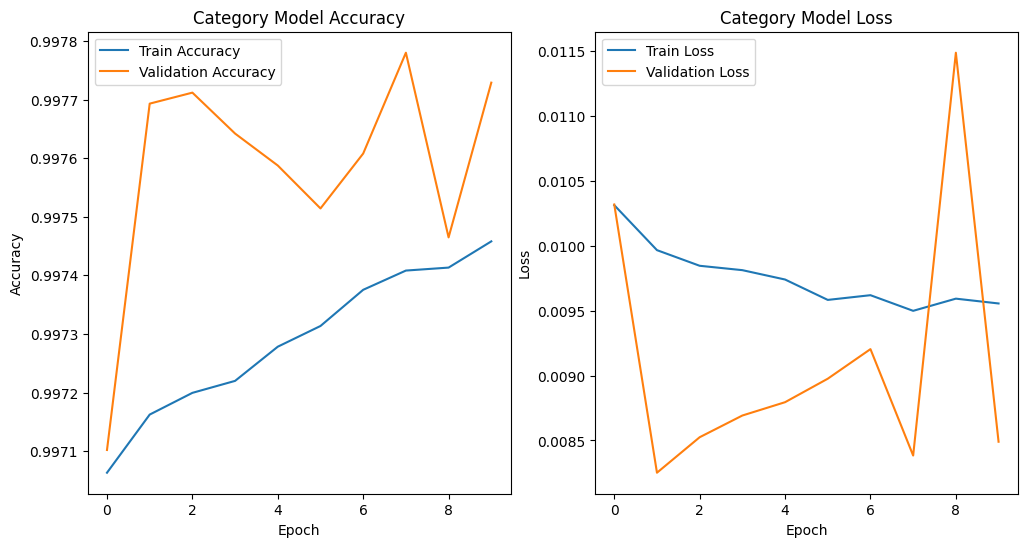

Epoch 1/10
73367/73367 [==============================] - 256s 3ms/step - loss: 0.0132 - accuracy: 0.9950 - val_loss: 0.0126 - val_accuracy: 0.9955
Epoch 2/10
73367/73367 [==============================] - 256s 3ms/step - loss: 0.0132 - accuracy: 0.9950 - val_loss: 0.0134 - val_accuracy: 0.9947
Epoch 3/10
73367/73367 [==============================] - 276s 4ms/step - loss: 0.0131 - accuracy: 0.9950 - val_loss: 0.0187 - val_accuracy: 0.9949
Epoch 4/10
73367/73367 [==============================] - 334s 5ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 0.0123 - val_accuracy: 0.9955
Epoch 5/10
73367/73367 [==============================] - 290s 4ms/step - loss: 0.0133 - accuracy: 0.9951 - val_loss: 0.0141 - val_accuracy: 0.9947
Epoch 6/10
73367/73367 [==============================] - 272s 4ms/step - loss: 0.0131 - accuracy: 0.9951 - val_loss: 0.0150 - val_accuracy: 0.9946
Epoch 7/10
73367/73367 [==============================] - 262s 4ms/step - loss: 0.0127 - accuracy: 0.9952 - val_

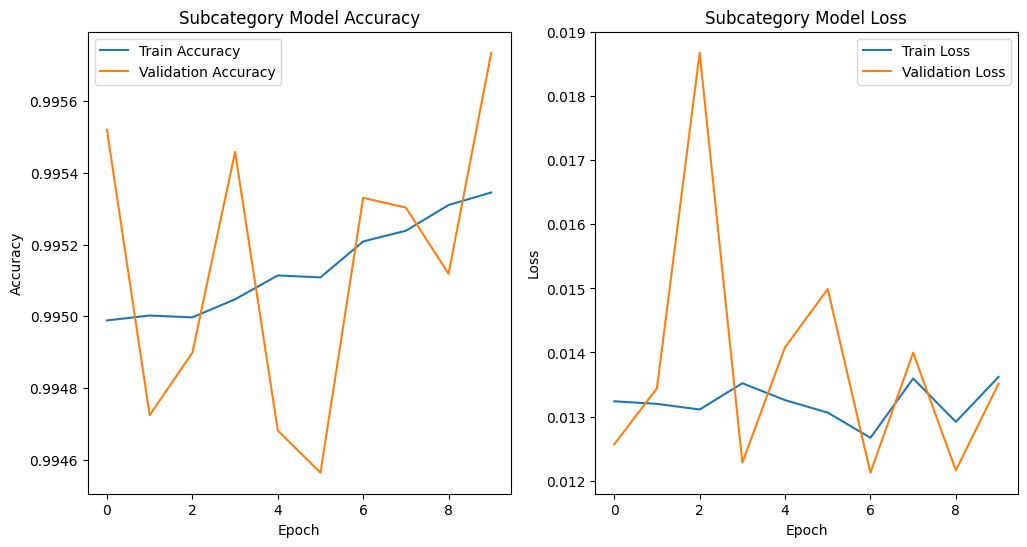

In [ ]:
import matplotlib.pyplot as plt

# Train the category model and store the history
history_category = model_category.fit(X_train_encoded_reshaped, y_train['category'], epochs=10, batch_size=32, validation_data=(X_test_encoded_reshaped, y_test['category']))

# Plot training & validation accuracy and loss for category
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_category.history['accuracy'], label='Train Accuracy')
plt.plot(history_category.history['val_accuracy'], label='Validation Accuracy')
plt.title('Category Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_category.history['loss'], label='Train Loss')
plt.plot(history_category.history['val_loss'], label='Validation Loss')
plt.title('Category Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Train the subcategory model and store the history
history_subcategory = model_subcategory.fit(X_train_encoded_reshaped, y_train['subcategory'], epochs=10, batch_size=32, validation_data=(X_test_encoded_reshaped, y_test['subcategory']))

# Plot training & validation accuracy and loss for subcategory
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_subcategory.history['accuracy'], label='Train Accuracy')
plt.plot(history_subcategory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Subcategory Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_subcategory.history['loss'], label='Train Loss')
plt.plot(history_subcategory.history['val_loss'], label='Validation Loss')
plt.title('Subcategory Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()